### Standardised Data

# FYP-DL: Wide and Deep Convolutional Neural Netork - Zheng

Using Zheng et. al's hyperparameters to build a wide and deep convolutional neural network. 

# Why?
- Both wide and deep (convolutional) neural networks complement each others' weaknesses. 
- Learn different **kinds** of features.
- Combine both of them into a single model -> better model (in theory). 


|     |    Good At    |    Bad At    |
|-----|:-------------:|:------------:|
| WNN | Memorizing    | Generalizing |
| CNN | Generalizing  | Memorizing   |

## Memorization
- According to [Cheng](https://arxiv.org/abs/1606.07792) et al, wide neural networks excel at memorization.
- Specifically, they are very good at learning cross-feature **interactions** that are associated with the target class.
- **Interactions** can be thought of as the co-occurence of specific features.
  - Cheng et. al discuss this only in the context of categorical features, not numerical ones.
- We can think of memorization as the process of learning rules involving feature co-occurences: the model **memorizes** rules like (if X and Y and Z then A).
- Drawback: model won't be able to recognize co-occurrences that aren't present in the training data. 

## Generalization
- CNNs are capable of learning new features from existing data that are more abstract than just simple co-occurrences.
- They are **feature extractors**: by looking at data at increasing levels of abstraction, they are able to create new feature spaces that are correlated with the target class.
- Cheng says CNNs and DNNs are good at generalization because this feature extraction helps them learn **exceptions to the rule**. 
- Drawback: Don't learn cross-feature interactions as well as WNNs.


# Imports

In [0]:
# Standard imports 
import numpy as np
import pandas as pd 
import os 

# For loading data from Google Drive
from google.colab import drive

# For building DL models
import tensorflow as tf
from tensorflow import keras        # Using the tf implementation of keras 

# Seed the random number generators
np.random.seed(0)
tf.random.set_seed(0)

# For plotting 
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')                        # Don't have to use this. Just a matter of preference
from seaborn import distplot, heatmap      # For visualizing feature distributions

# Scikit Imports

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Functions

## scale_features

In [0]:
def scale_features(X, scaling_strategy='Standard', plot_distributions=False):
  """Allows user to scale features for individual samples using specified scaling strategy.
  `Standard` - all features scaled to have mean 0, standard deviation of 1
  `MinMax` - all features scaled according to x - x_min / (x_max - x_min)
  `MaxAbs` - all features scaled according to x / abs(x_max)
  
  Returns matrix of scaled features as a numpy array.

  Also allows before/after plots of feature values to compare effect of scaling
  """
  # StandardScaler - all features will have mean of 0, and std deviation of 1
  if (scaling_strategy=='Standard'):
    # Instantiate a StandardScaler object
    scaler = StandardScaler()
  elif (scaling_strategy=='MinMax'):
    scaler = MinMaxScaler()
  elif (scaling_strategy=='MaxAbs'):
    scaler = MaxAbsScaler()

  # Make a copy of the features, transpose so that consumers become columns
  X_copy = X.copy().transpose()

  # Once consumers are in columns, scale each consumer using scaler object and retranspose results 
  # Retransposing ensures that in scaled data, the consumers are still rows
  X_scaled = scaler.fit_transform(X_copy).transpose() # THIS IS A NUMPY ARRAY, NOT A DATAFRAME

  # If the user has asked to compare distributions
  if plot_distributions:
    # First figure - before scaling
    plt.figure(figsize=(12, 6))
    distplot(X.values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Unscaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - Before Scaling', fontsize=18)

    # Second figure - after scaling
    plt.figure(figsize=(12, 6))
    distplot(X_scaled.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Scaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - After {} Scaling'.format(scaling_strategy), fontsize=18)

  # Return the scaled features
  return X_scaled

## plot_history

In [0]:
def plot_history(history, model_name=None, figsize=(12, 6), 
                 loss_name='Binary Crossentropy'):
  # Extract loss from the history object
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  # Extract AUCs
  auc = None
  val_auc = None

  # Extract `auc` and `val_auc` regardless of last number in key
  for key in list(history.history.keys()):
    if 'auc' in key and 'val' not in key:
      auc = history.history[key]
    elif 'auc'in key and 'val' in key:
      val_auc = history.history[key]

  # Plotting Loss
  plt.figure(figsize=figsize)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs', fontsize=14)
  plt.ylabel(loss_name, fontsize=14)
  plt.title('Loss ' + ('' if model_name is None else ' - {}'.format(model_name)), 
            fontsize=18)
  plt.legend(loc='lower right')

  # Plotting AUC - only if in dictionary
  if auc is not None and val_auc is not None:
    plt.figure(figsize=figsize)
    plt.plot(epochs, auc, label='Training AUC')
    plt.plot(epochs, val_auc, label='Validation AUC')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.title('AUC ' + ('' if model_name is None else' - {}'.format(model_name)), 
              fontsize=18)

## convert_functional_probas

Middleware to convert the predicted probabiliteis of a WDNN into a format that is compatible with 

In [0]:
def get_functional_model_preds(model, X_test, batch_size=None, output_name='wdnn_output', 
                               threshold=0.5):
  
  # Predicted probabilities of the example belonging to the target class
  # Because functional API returns dictionary of outputs, must index using output name
  # And then unravel to create a single-dimensional array
  y_probas = model.predict(X_test, batch_size=batch_size)[output_name].ravel()

  # Convert to predicted class labels - 0 or 1 - based on threshold
  y_classes = (y_probas > threshold).astype('uint8')

  # Return both the probability and the class labels
  return y_classes, y_probas

## classification_result

In [0]:
def get_classification_result(model, X_test, y_true, model_name=None, 
                              normalize_conf_mat='all'):
  """Displays classification report, confusion matrix, and ROC curve for a trained
  model using classification results on data provided"""
  # PREDICTIONS
  # First, get the predictions for the test data - batch size must be smaller
  # than default 32, otherwise we'll run out of memory during prediction for WDNN
  y_pred, y_probas = get_functional_model_preds(model, X_test)

  # CLASSIFICATION REPORT
  print("classification report".upper(), end='\n')
  print(classification_report(y_true, y_pred, labels=[0, 1], 
                              target_names=['Regular Consumer', 'Thief']))
  
  # CONFUSION MATRIX
  if (normalize_conf_mat=='rows'):
    normalize='true'
  elif (normalize_conf_mat=='cols'):
    normalize='pred'
  else:
    normalize='all'

  # Using Seaborn to plot confusion matrix as a heatmap 
  conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize)

  # Create a heatmap in lieu of the plot_confusion_matrix call in sklearn
  plt.figure(figsize=(8, 8))
  heatmap(conf_mat, annot=True, fmt='.5g', cmap='Blues', 
        xticklabels=['Predicted Reg', 'Predicted Thief'], 
        yticklabels=['True Reg', 'True Thief'])
  plt.title('Confusion Matrix ' + ('' if model_name is None else ' - ' + model_name))

  # ROC Curve
  plt.figure(figsize=(8, 8))
  fpr, tpr, _ = roc_curve(y_true, y_probas, pos_label=1)
  roc_auc = roc_auc_score(y_true, y_probas)
  plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title('ROC Curve' + ('' if model_name is None else (' - ' + model_name)))
  plt.legend(loc='lower right')
  

## training_trends

In [0]:
def plot_training_trends(history_list, labels_list, suptitle):
  # Empty lists first
  lost_lists = []
  val_loss_lists = []
  auc_lists = []
  val_auc_lists = []

  # Extracting list of training losses 
  loss_lists = [history.history['loss'] for history in history_list]
  val_loss_lists = [history.history['val_loss'] for history in history_list]

  # Epochs will be the same as the length of any given loss list
  epochs = range(1, len(loss_lists[0]) + 1)

  # Extracting list of accuracies will be more difficult - uses functions defined earlier
  auc_lists = get_auc(history_list)
  val_auc_lists = get_val_auc(history_list)

  # Labels for each plot in same order as dropout rates of models
  legend_labels = labels_list

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 10))

  for i in range(0, len(loss_lists)):
    ax1.plot(epochs, loss_lists[i])
    ax2.plot(epochs, val_loss_lists[i])
    ax3.plot(epochs, auc_lists[i])
    ax4.plot(epochs, val_auc_lists[i])

  for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('Epochs')
    ax.legend(legend_labels) 

  ax1.set_title('Training Loss'); ax2.set_title('Validation Loss')
  ax3.set_title('Training AUC'); ax4.set_title('Validation AUC')
  fig.suptitle(suptitle, fontsize=18)

# Loading Data

## Defining Filepaths

In [6]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Define filepaths
ROOT_DIR = '/content/drive/My Drive'
FYP_DIR = 'EE 16-17 FYP DL Energy Theft Detection'
DATA_DIR  = 'Data/full-processing-data'
DATA_RAW = 'outliersRemoved.csv'

# Combining filepaths
DATA_FILEPATH = os.path.join(ROOT_DIR, FYP_DIR, DATA_DIR, DATA_RAW)

## Creating `DataFrame`

In [0]:
# Read data from CSV
df = pd.read_csv(DATA_FILEPATH)

In [9]:
# Did it work?
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


In [10]:
# Any missing values in this dataset?
df.values[np.where(np.isnan(df.iloc[:, 1:].values))[0], :]

array([], shape=(0, 1036), dtype=object)

## Extracting Features and Labels

In [0]:
# Second column - FLAG - is the target
targets = df['FLAG']

In [0]:
# Third column onwards are kWhs - these are our features
features = df.iloc[:, 2:]

## Scale Features

Creating separate arrays prepared using standard and minmax scalers.

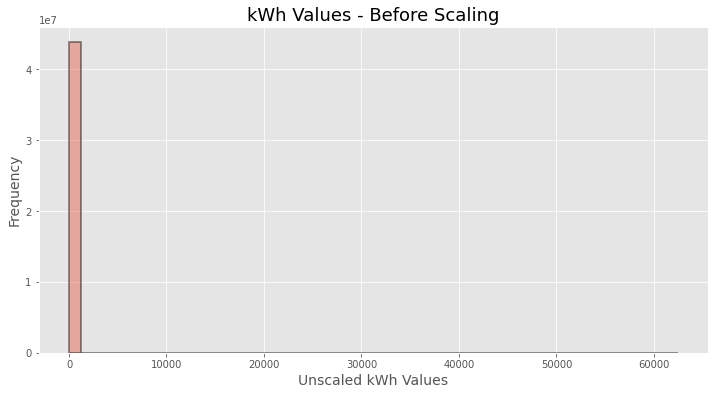

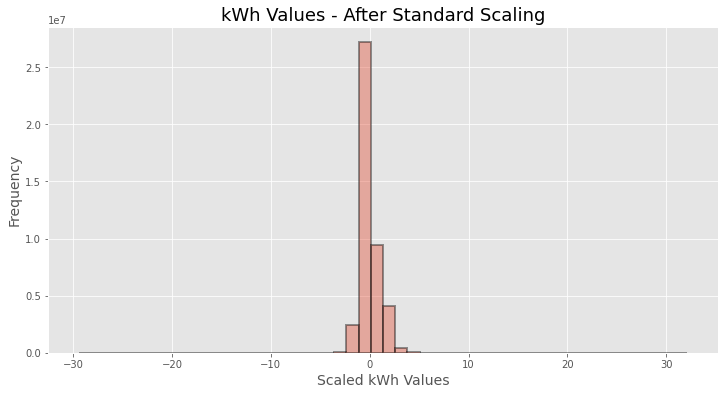

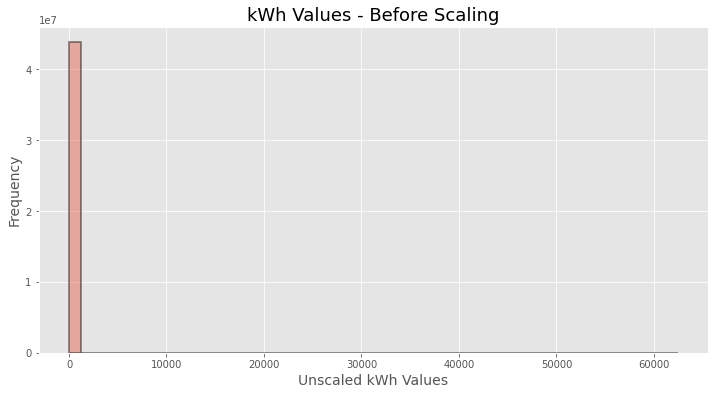

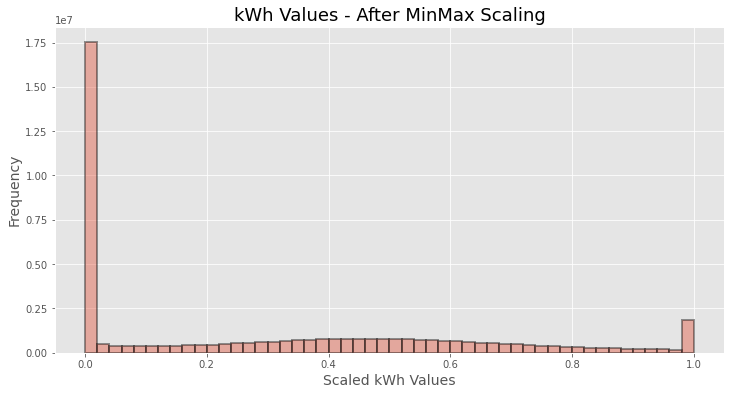

In [13]:
X_scaled_std = scale_features(features, plot_distributions=True)
X_scaled_minmax = scale_features(features, scaling_strategy='MinMax', plot_distributions=True)

In [14]:
# Any missing values after this transformation?
print(np.any(np.isnan((X_scaled_std))))
print(np.any(np.isnan(X_scaled_minmax)))

False
False


## Train-Test Split

In [0]:
# Standard scaled data
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_scaled_std, targets, 
                                                                    random_state=0, 
                                                                    shuffle=True, 
                                                                    test_size=0.2,
                                                                    stratify=targets.values)     # Must be numpy array for stratification|

In [0]:
# Minmax scaled data
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(
    X_scaled_minmax, targets, random_state=0, shuffle=True, stratify=targets.values, test_size=0.2
)

## Checking Train-Test Split

In [0]:
# Confirming both feature sets are similar
assert X_train_std.shape == X_train_minmax.shape
assert X_test_std.shape == X_test_minmax.shape

# Confirming 1-1 mapping between targets and labels
assert len(X_train_minmax) == len(y_train_minmax)
assert len(X_test_minmax) == len(y_test_minmax)
assert len(X_train_std) == len(y_train_std)
assert len(X_test_std) == len(y_test_std) 

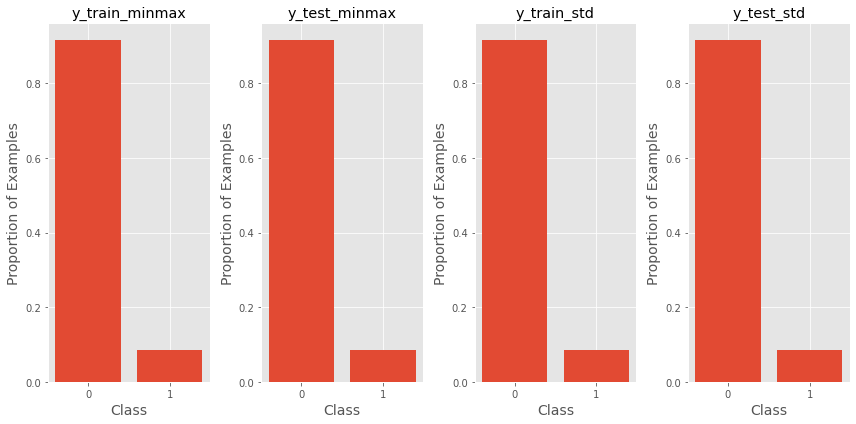

In [18]:
# Confirming class distributions are same 
data_dict = {
    'y_train_minmax': y_train_minmax, 
    'y_test_minmax': y_test_minmax, 
    'y_train_std': y_train_std, 
    'y_test_std': y_test_std
}

fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i, ((arr_name, label_arr)) in enumerate(data_dict.items()):
  plt.sca(axes[i])
  plt.bar([0, 1], (pd.Series(label_arr).value_counts() / len(label_arr)))
  plt.xticks([0, 1])
  plt.title(arr_name)
  plt.xlabel('Class', fontsize=14)
  plt.ylabel('Proportion of Examples', fontsize=14)

plt.tight_layout()

## Padding Data 

- CNN expects data to be two-dimensional.
- This can only be done if there are enough features for `n_features / 7` to be a whole number.
- With 1,034 features per consumer, we are just about shy of 148 weeks of data.
- So pad the all training features with 2 additional columns of zeroes. 

In [0]:
# Features common to all examples
NUM_FEATURES = features.shape[-1]

# Have already asserted that the minmax data has the same number of entries
NUM_TRAIN = len(X_train_std)
NUM_TEST = len(X_test_std)

# Number of columns to add to the CNN data
PADDING = 2 

# For reshaping
DAYS_PER_WEEK = 7
PADDING = 2
WEEKS_PER_CONSUMER = int((NUM_FEATURES + PADDING) / DAYS_PER_WEEK)

## Reshaping Data

### Reshaping Function

In [0]:
def get2DFeatures(features_arr):
  """Transforms 1D array of features into a 2D array suitable for use with a CNN"""
  # First, find some metrics for reshaping
  num_samples = len(features_arr)

  # Create a new array of features by appending 2 columns of zeros to the existing features
  modified_features = np.append(features_arr, axis=1, values=np.zeros((num_samples, 2)))

  # Reshape into a 3D array of dimensions (samples, weeks, days) - each consumer is now a 3D array
  # of type (samples, week number, day number, channel) - channel is necessary for CNN.
  return modified_features.reshape((num_samples, WEEKS_PER_CONSUMER, DAYS_PER_WEEK, 1))

### Reshaping MinMax Features

In [0]:
# MINMAX
X_train_minmax_2D = get2DFeatures(X_train_minmax)
X_test_minmax_2D = get2DFeatures(X_test_minmax)

# Also creating targets - need separate arrays for validation set
y_train_minmax_2D = y_train_minmax.copy()
y_test_minmax_2D = y_test_minmax.copy()

### Reshaping Standard Scaler Features

In [0]:
# STANDARD SCALER DATA
X_train_std_2D = get2DFeatures(X_train_std)
X_test_std_2D = get2DFeatures(X_test_std)

# Also creating targets - will need these for validation set
y_train_std_2D = y_train_minmax.copy()
y_test_std_2D = y_test_minmax.copy() 

### Testing Reshaping

In [23]:
# First, confirm that each sample is a matrix of 2D features -> 3D arrays of train/test data
np.all([feature_arr.ndim == 4 for feature_arr in [X_train_std_2D, X_test_std_2D, X_train_minmax_2D, X_test_minmax_2D]])

True

In [0]:
# Then check that the samples axis is unchanged 
original_features = [X_train_minmax, X_test_minmax, X_train_std, X_test_std]
reshaped_features = [X_train_minmax_2D, X_test_minmax_2D, X_train_minmax_2D, X_test_minmax_2D]

# Compare corresponding arrays
for (original_arr, reshaped_arr) in zip(original_features, reshaped_features):
  assert len(original_arr) == len(reshaped_arr)

# WDNN

## Inputs

Since we're using the functional API, we are defining the inputs for the WNN and CNN separately as tensors of specific dimensions.

Providing a `name` for these inputs is optional, but, as we'll see when fitting the model, it makes it much easier to pass data to the model. 

We aren't specifying the size of the `sample` axis either tensor. This means the NN will be able to accept whatever batch size we provide to it.

In [0]:
# (dim1, ) means the sample axis can have any size -> same applies to 2D inputs as well
wnn_input = keras.layers.Input(shape=(NUM_FEATURES,), name='wnn_input')
cnn_input = keras.layers.Input(shape=(WEEKS_PER_CONSUMER, DAYS_PER_WEEK, 1), name='cnn_input')

## Hidden Layers - WNN

The WNN consists of a single densely connected hidden layer. This layer transforms the Wide Neural Network's input.

We used 50 in the original WNN, but I had to change it to 60 for merging the layers OP with that of the CNN. 

Detailed explanation is just a few cells down. 

In [0]:
# Only one hidden layer in WNN - 60 ReLu units
wnn_dense_1 = keras.layers.Dense(activation='relu', units=60)(wnn_input)

## Hidden Layers - CNN

### Successsive Convolutional layers

In [0]:
# First convolutional layer
cnn_conv_1 = keras.layers.Conv2D(filters=18, activation='relu', 
                                   padding='same', kernel_size=(3, 3))(cnn_input)

# Second Conv2D
cnn_conv_2 = keras.layers.Conv2D(filters=36, activation='relu', 
                                   padding='same', kernel_size=(3, 3))(cnn_conv_1)

# Third Conv2D
cnn_conv_3 = keras.layers.Conv2D(filters=72, activation='relu', 
                                   padding='same', kernel_size=(3, 3))(cnn_conv_2)

# Fourth Conv2D
cnn_conv_4 = keras.layers.Conv2D(filters=144, activation='relu', 
                                   padding='same', kernel_size=(3, 3))(cnn_conv_3)

# Fifth Conv2D
cnn_conv_5 = keras.layers.Conv2D(filters=288, activation='relu',
                                   padding='same', kernel_size=(3, 3))(cnn_conv_4)

### Max Pooling 

there is a single max pooling layer after a series of convolutional layers. 

In [0]:
cnn_max_pooling2d = keras.layers.MaxPooling2D(pool_size=(3, 3))(cnn_conv_5)

### Fully Connected Classifier

This is still part of the CNN. The output of the max pooling layer of the CNN is flattened and then fed to densely connected feedforward neural network.

In [0]:
# Flatten before feeding to the dnn 
cnn_flatten = keras.layers.Flatten()(cnn_max_pooling2d)

# Hope this works
cnn_dense_1 = keras.layers.Dense(units=60, activation='relu')(cnn_flatten)

## Merging WNN/CNN Outputs

The paper states, in the very last paragraph of page 5, that the outputs of the wide and convolutional networks are **added** as a weighted sum. 

*Finally, the Wide component and the Deep CNN component
are **combined using a weighted sum** of their output as hidden
features"*

I'm assuming this means I should use an `add` layer instead of the usual `concatenate`.

### Is `add` the right merging function?
If I use `add`, it will require the dimension of the WNN's hidden layer OP to be the same as that of the last layer of the CNN's densely connected classifier. 

This is a problem: Zheng seems to have used 50 units in the WNN hidden layer and 60 units in the CNN's densely connected classifier. So when I try and `add` these tensors together, I get the following error
```python
ValueError: Operands could not be broadcast together with shapes (60,) (50,)
```

For now, I'm changing the WNN's OP to 50 units. This will help in two ways
- it will resolve the dimensionality error.
- the WNN seems to suffer from low learning capacity (its trying to learn cross-feature interactions if 1034-dimensional vectors with only 50 units!). Increasing units will result in a (modest) increase in its learning capacity.

In [0]:
merged_outputs = keras.layers.add(inputs=[cnn_dense_1, wnn_dense_1])

## Outputs

I will use the tensor transformations described by these ^ layers to build three models
1. A Wide Neural Network
2. A Deep Neural Netwok
3. A Wide and Deep Neural Network

Each of them will have different output layers. So need to define them separately.

### WNN Output

The WNN output is simply the result of passing the WNN's densely connected layer's outout to a sigmoid activation.

In [0]:
wnn_output = keras.layers.Dense(units=1, activation='sigmoid', name='wnn_output')(wnn_dense_1)

### CNN Output

The output of the standalone CNN model is the result of passing the densely connected classifier's output to a sigmoid activation unit.

In [0]:
cnn_output = keras.layers.Dense(units=1, activation='sigmoid', name='cnn_output')(cnn_dense_1)

### WDNN Output

The WDNN's output is the result of passing a weighted sum of outputs from the WNN and CNN's last dense layers to a single sigmoid activation unit.

In [0]:
wdnn_output = keras.layers.Dense(units=1, activation='sigmoid', name='main_output')(merged_outputs)

## Building Models

Because I've defined tensor transformations using the functional API, I can now mix and match these layers to create three different models.

1. Wide neural network
2. Deep convolutional neural network
3. Wide and Deep Convolutional Neural Network

### WDNN

In [0]:
wdnn_model = keras.models.Model(inputs={'wnn_input': wnn_input, 'cnn_input': cnn_input}, 
                                outputs={'wdnn_output': wdnn_output})

### Visualizing WDNN

What does the model look like?

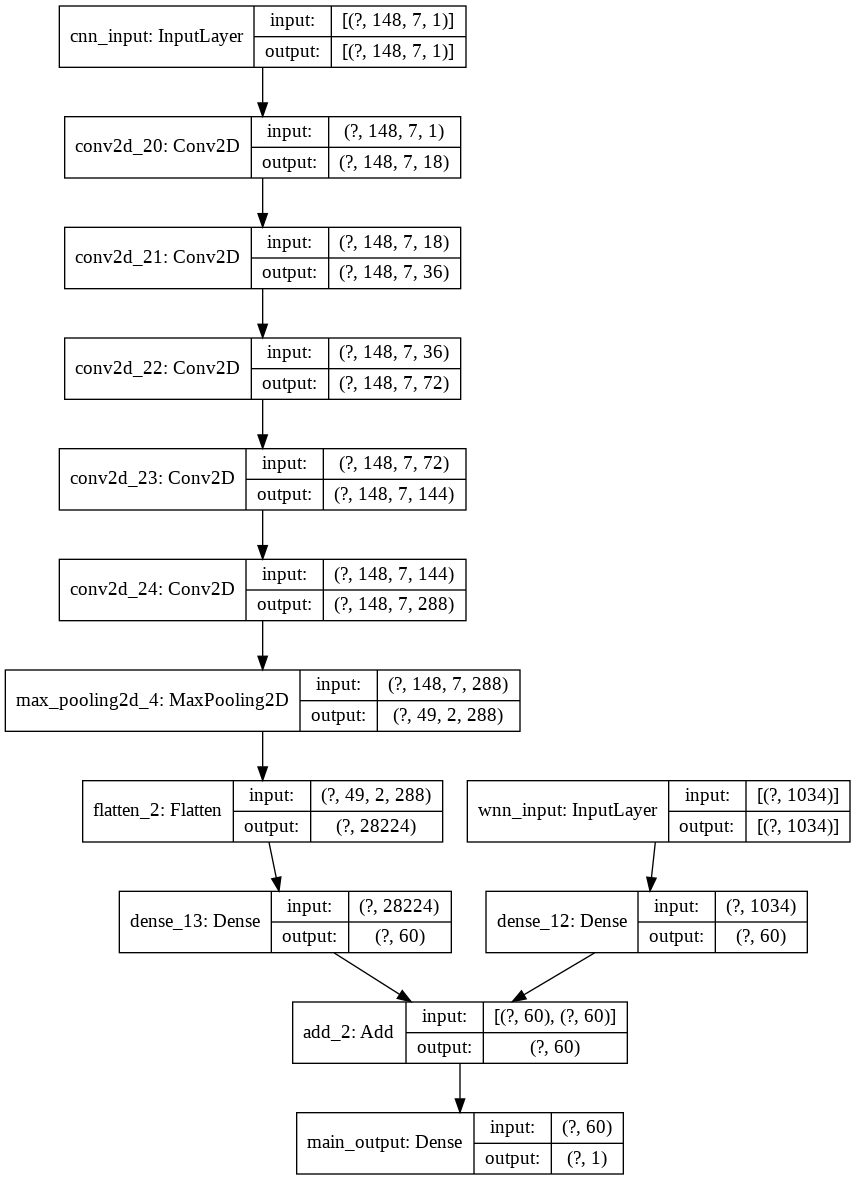

In [78]:
keras.utils.plot_model(wdnn_model, to_file='wdnn_network.png', show_shapes=True, 
                       show_layer_names=True)

### Model Summary

In [79]:
wdnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 148, 7, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 148, 7, 18)   180         cnn_input[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 148, 7, 36)   5868        conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 148, 7, 72)   23400       conv2d_21[0][0]                  
____________________________________________________________________________________________

# Standalone Models

For comparison, I am also going to build the standalone WNN and CNNs with the same hyperparameters as in the WDNN.

## WNN

### Building Model

In [0]:
wnn_model = keras.models.Sequential([
            keras.layers.Dense(input_shape=(1034,), activation='relu', units=60),
            keras.layers.Dense(units=1, activation='sigmoid')
])

### Model Summary

In [81]:
wnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 60)                62100     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 61        
Total params: 62,161
Trainable params: 62,161
Non-trainable params: 0
_________________________________________________________________


### Model Plot

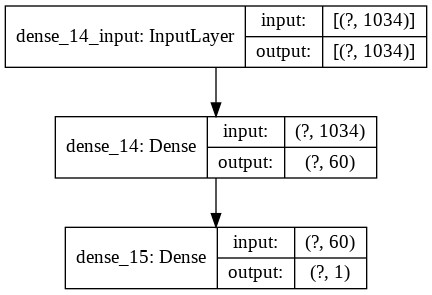

In [82]:
keras.utils.plot_model(wnn_model, to_file='wnn_model.png', show_shapes=True, 
                       show_layer_names=True)

## CNN Model 

### Building Model

In [0]:
cnn_model = keras.models.Sequential([
            # Sequence of 5 Conv2D layers
            keras.layers.Conv2D(input_shape=(WEEKS_PER_CONSUMER, DAYS_PER_WEEK, 1), 
                                filters=18, activation='relu', kernel_size=(3, 3), padding='same'),
            keras.layers.Conv2D(filters=36, activation='relu', kernel_size=(3, 3), padding='same'),
            keras.layers.Conv2D(filters=72, activation='relu', kernel_size=(3, 3), padding='same'),
            keras.layers.Conv2D(filters=144, activation='relu', kernel_size=(3, 3), padding='same'),
            keras.layers.Conv2D(filters=288, activation='relu', kernel_size=(3, 3), padding='same'),

            # Single Max Pooling layer,
            keras.layers.MaxPooling2D(pool_size=(3, 3)),

            # Densely connected classifier 
            keras.layers.Dense(units=60, activation='relu'),
            keras.layers.Dense(units=1, activation='sigmoid')
])

### Model Summary

In [84]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 148, 7, 36)        5868      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 148, 7, 72)        23400     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 148, 7, 144)       93456     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 148, 7, 288)       373536    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 2, 288)        0         
_________________________________________________________________
dense_16 (Dense)             (None, 49, 2, 60)        

### Model Plot

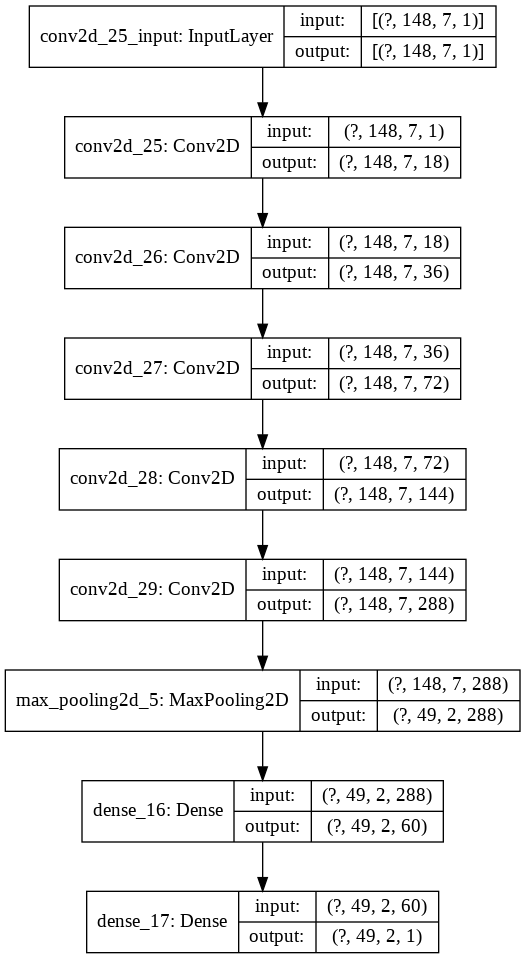

In [85]:
keras.utils.plot_model(cnn_model, show_shapes=True, show_layer_names=True)

# Compiling Models

Using `adam` optimizer to minimize `binary_crossentropy` loss while measuring `AUC` for all three models.

In [0]:
for model in [wnn_model, cnn_model, wdnn_model]:
  model.compile(loss='binary_crossentropy', metrics=keras.metrics.AUC(), 
                optimizer='adam')

# Training Models

## WDNN - Standard Scaler Data

### Training

In [87]:
wdnn_history = wdnn_model.fit(x=[X_train_std_2D, X_train_std], y=y_train_std, 
                              epochs=10, batch_size=128, verbose=1)

Epoch 1/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2927 - auc_11: 0.6591
Epoch 2/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2517 - auc_11: 0.7683
Epoch 3/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2288 - auc_11: 0.8234
Epoch 4/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2100 - auc_11: 0.8590
Epoch 5/10
265/265 [==============================] - 13s 48ms/step - loss: 0.1922 - auc_11: 0.8870
Epoch 6/10
265/265 [==============================] - 13s 48ms/step - loss: 0.1670 - auc_11: 0.9179
Epoch 7/10
265/265 [==============================] - 13s 48ms/step - loss: 0.1418 - auc_11: 0.9431
Epoch 8/10
265/265 [==============================] - 13s 48ms/step - loss: 0.1150 - auc_11: 0.9642
Epoch 9/10
265/265 [==============================] - 13s 48ms/step - loss: 0.0900 - auc_11: 0.9790
Epoch 10/10
265/265 [==============================] - 13s 48ms/step - loss: 0.0639 - auc_11: 0.9892

### Saving Weights

In [0]:
wdnn_model.save('wdnn_standard_zheng.h5')

### Plotting Training History

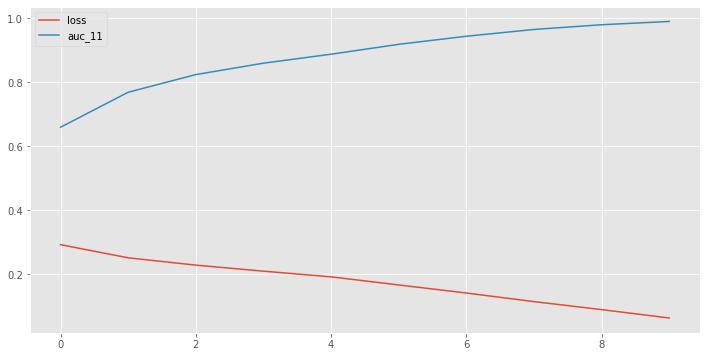

In [95]:
pd.DataFrame(wdnn_history.history).plot(figsize=(12, 6 ))

### Evaluation 

In [109]:
wdnn_model.evaluate([X_test_std_2D, X_test_std], y_test_std)

265/265 [==============================] - 2s 6ms/step - loss: 0.4204 - auc_11: 0.7521


[0.4204268157482147, 0.7520744800567627]

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.96      7752
           Thief       0.52      0.27      0.35       723

        accuracy                           0.92      8475
       macro avg       0.73      0.62      0.66      8475
    weighted avg       0.90      0.92      0.90      8475



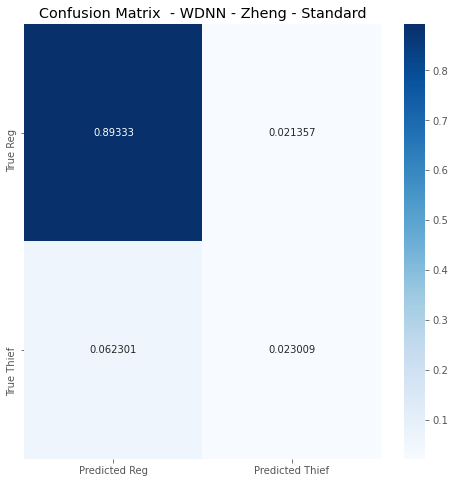

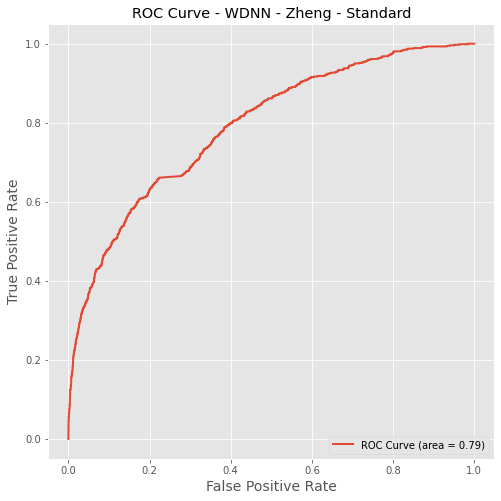

In [192]:
get_classification_result(model=wdnn_model, X_test=[X_test_std_2D, X_test_std], 
                          y_true=y_test_std, model_name='WDNN - Zheng - Standard')

## WDNN - MinMax Scaler Data

### Training

In [204]:
wdnn_history = wdnn_model.fit(x=[X_train_minmax_2D, X_train_minmax], y=y_train_minmax, 
                              epochs=10, batch_size=128, verbose=1)

Epoch 1/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2805 - auc_14: 0.6593
Epoch 2/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2666 - auc_14: 0.7083
Epoch 3/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2576 - auc_14: 0.7407
Epoch 4/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2485 - auc_14: 0.7669
Epoch 5/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2404 - auc_14: 0.7886
Epoch 6/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2309 - auc_14: 0.8095
Epoch 7/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2234 - auc_14: 0.8233
Epoch 8/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2102 - auc_14: 0.8511
Epoch 9/10
265/265 [==============================] - 13s 48ms/step - loss: 0.2000 - auc_14: 0.8681
Epoch 10/10
265/265 [==============================] - 13s 48ms/step - loss: 0.1865 - auc_14: 0.8877

### Saving Weights

In [0]:
wdnn_model.save('wdnn_minmax_zheng.h5')

### Plotting Training History

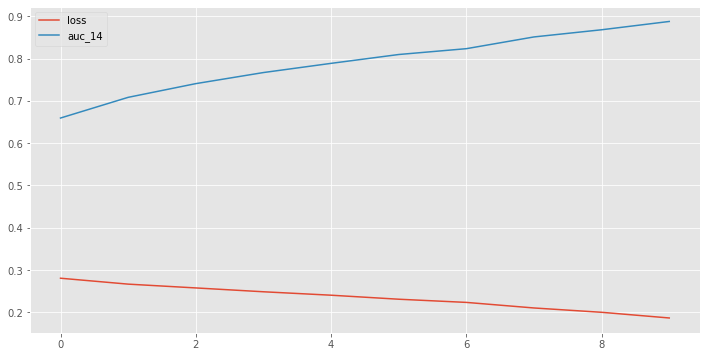

In [209]:
pd.DataFrame(wdnn_history.history).plot(figsize=(12, 6))

### Evaluation

In [210]:
wdnn_model.evaluate([X_test_minmax_2D, X_test_minmax], y_test_minmax)

265/265 [==============================] - 2s 6ms/step - loss: 0.2544 - auc_14: 0.7781


[0.2544266879558563, 0.7780818939208984]

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.98      0.96      7752
           Thief       0.58      0.25      0.35       723

        accuracy                           0.92      8475
       macro avg       0.76      0.61      0.65      8475
    weighted avg       0.90      0.92      0.91      8475



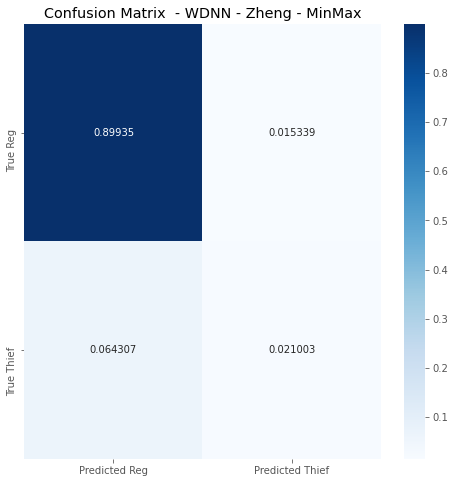

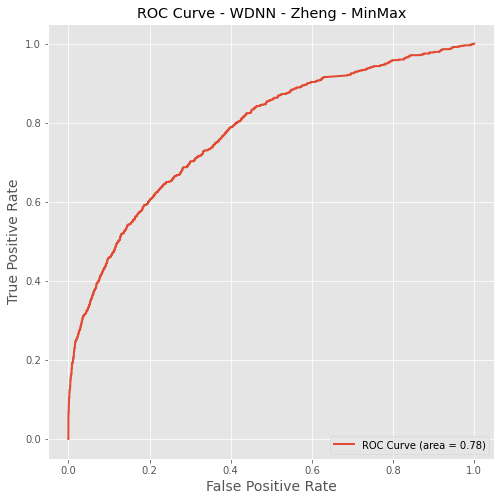

In [211]:
get_classification_result(model=wdnn_model, X_test=[X_test_minmax_2D, X_test_minmax], 
                          y_true=y_test_minmax, model_name='WDNN - Zheng - MinMax')